# Importation

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import keras.backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.linear_model import LinearRegression

from sklearn.decomposition import PCA #PCA
from sklearn.cluster import KMeans, DBSCAN #clustering methods

from tqdm.notebook import tqdm
tqdm.pandas

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split

from keras import callbacks
from keras.models import Model
from keras.datasets import mnist
from IPython.display import Image
from sklearn.cluster import KMeans
from keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD
from keras.utils.vis_utils import plot_model
from keras.initializers import VarianceScaling
from tensorflow.keras.layers import Layer, InputSpec
from scipy.optimize import linear_sum_assignment as linear_assignment

# Load data

In [2]:
#employee = pd.read_csv(os.path.join("..","..","..", "data","attrition", "employee_process.csv"))
employee = pd.read_csv("employee_process.csv")

In [3]:
X = employee.copy()
X.head()

,age,y,dailyrate,distancefromhome,education,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,monthlyrate,numcompaniesworked,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,businesstravel_non_travel,businesstravel_travel_frequently,businesstravel_travel_rarely,department_human_resources,department_research_development,department_sales,educationfield_human_resources,educationfield_life_sciences,educationfield_marketing,educationfield_medical,educationfield_other,educationfield_technical_degree,jobrole_healthcare_representative,jobrole_human_resources,jobrole_laboratory_technician,jobrole_manager,jobrole_manufacturing_director,jobrole_research_director,jobrole_research_scientist,jobrole_sales_executive,jobrole_sales_representative,maritalstatus_divorced,maritalstatus_married,maritalstatus_single
0,41,1,1102,1,2,2,0,94,3,2,4,5993,19479,8,1,11,3,1,0,8,0,1,6,4,0,5,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,49,0,279,8,1,3,1,61,2,2,2,5130,24907,1,0,23,4,4,1,10,3,3,10,7,1,7,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,37,1,1373,2,2,4,1,92,2,1,3,2090,2396,6,1,15,3,2,0,7,3,3,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
3,33,0,1392,3,4,4,0,56,3,1,3,2909,23159,1,1,11,3,3,0,8,3,3,8,7,3,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,27,0,591,2,1,1,1,40,3,1,2,3468,16632,9,0,12,3,4,1,6,3,3,2,2,2,2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [4]:
augmentation =[ ]
for var in X.columns :
    if X[var].unique().tolist() == [0,1] :
        pass
    elif X[var].unique().tolist() ==[1,0]:
        pass
    else :
        augmentation.append(var)

In [5]:
X_nl = X.copy()

for var in augmentation :
    
    X_nl[var+'_squared'] = X_nl[var]**2
    X_nl[var+'_cube'] = X_nl[var]**3

In [6]:
for i in range(len(augmentation)-1):
     X_nl[augmentation[i]+'_'+augmentation[i+1]] = X_nl[augmentation[i]]*X_nl[augmentation[i+1]]

In [7]:
scaler = MinMaxScaler()
X_process = scaler.fit_transform(X_nl)
X_process = pd.DataFrame(X_process, columns = X_nl.columns)

In [8]:
print(X_process.shape)
X_process.head()

(1470, 118)


,age,y,dailyrate,distancefromhome,education,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,monthlyrate,numcompaniesworked,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,businesstravel_non_travel,businesstravel_travel_frequently,businesstravel_travel_rarely,department_human_resources,department_research_development,department_sales,educationfield_human_resources,educationfield_life_sciences,educationfield_marketing,educationfield_medical,educationfield_other,educationfield_technical_degree,jobrole_healthcare_representative,jobrole_human_resources,...,relationshipsatisfaction_squared,relationshipsatisfaction_cube,stockoptionlevel_squared,stockoptionlevel_cube,totalworkingyears_squared,totalworkingyears_cube,trainingtimeslastyear_squared,trainingtimeslastyear_cube,worklifebalance_squared,worklifebalance_cube,yearsatcompany_squared,yearsatcompany_cube,yearsincurrentrole_squared,yearsincurrentrole_cube,yearssincelastpromotion_squared,yearssincelastpromotion_cube,yearswithcurrmanager_squared,yearswithcurrmanager_cube,age_dailyrate,dailyrate_distancefromhome,distancefromhome_education,education_environmentsatisfaction,environmentsatisfaction_hourlyrate,hourlyrate_jobinvolvement,jobinvolvement_joblevel,joblevel_jobsatisfaction,jobsatisfaction_monthlyincome,monthlyincome_monthlyrate,monthlyrate_numcompaniesworked,numcompaniesworked_percentsalaryhike,percentsalaryhike_performancerating,performancerating_relationshipsatisfaction,relationshipsatisfaction_stockoptionlevel,stockoptionlevel_totalworkingyears,totalworkingyears_trainingtimeslastyear,trainingtimeslastyear_worklifebalance,worklifebalance_yearsatcompany,yearsatcompany_yearsincurrentrole,yearsincurrentrole_yearssincelastpromotion,yearssincelastpromotion_yearswithcurrmanager
0,0.547619,1.0,0.715820,0.000000,0.25,0.333333,0.0,0.914286,0.666667,0.25,1.000000,0.262454,0.698053,0.888889,1.0,0.000000,0.0,0.000000,0.000000,0.200,0.0,0.000000,0.15,0.222222,0.000000,0.294118,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.040000,0.008000,0.00,0.000,0.000000,0.000000,0.0225,0.003375,0.049383,0.010974,0.000000,0.000000,0.086505,0.025443,0.487660,0.023662,0.006944,0.157895,0.427027,0.680217,0.263158,0.368421,0.292263,0.218987,0.662788,0.425121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.044118,0.040404,0.000000,0.000000
1,0.738095,0.0,0.126700,0.250000,0.00,0.666667,1.0,0.442857,0.333333,0.25,0.333333,0.217009,0.916001,0.111111,0.0,0.857143,1.0,1.000000,0.333333,0.250,0.5,0.666667,0.25,0.388889,0.066667,0.411765,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,0.111111,0.037037,0.062500,0.015625,0.25,0.125,0.533333,0.412698,0.0625,0.015625,0.151235,0.058813,0.004444,0.000296,0.169550,0.069815,0.126957,0.050643,0.048611,0.105263,0.413514,0.246612,0.157895,0.157895,0.117117,0.240518,0.105935,0.111111,0.880597,1.000000,0.333333,0.092593,0.138889,0.375,0.220588,0.117845,0.025926,0.027451
2,0.452381,1.0,0.909807,0.035714,0.25,1.000000,1.0,0.885714,0.333333,0.00,0.666667,0.056925,0.012126,0.666667,1.0,0.285714,0.0,0.333333,0.000000,0.175,0.5,0.666667,0.00,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.200000,0.111111,0.000000,0.000000,0.030625,0.005359,0.25,0.125,0.533333,0.412698,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.551980,0.062916,0.020833,0.368421,0.913514,0.414634,0.052632,0.105263,0.066152,0.000994,0.061144,0.434783,0.179104,0.230769,0.000000,0.000000,0.097222,0.375,0.000000,0.000000,0.000000,0.000000
3,0.357143,0.0,0.923407,0.071429,0.75,1.000000,0.0,0.371429,0.666667,0.00,0.666667,0.100053,0.845814,0.111111,1.0,0.000000,0.0,0.666667,0.000000,0.200,0.5,0.666667,0.20,0.388889,0.200000,0.000000,0.0,1.0,0.0,0.0,1.

In [9]:
y = X_process["y"]
X_process = X_process.drop(columns=['y'])
X_process = X_process.to_numpy()

In [10]:
X_process.shape

(1470, 117)

# Accuracy measure

In [11]:
def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_assignment(w.max() - w)
    return sum(w[ind[0], ind[1]]) * 1.0 / y_pred.size

In [49]:
from sklearn.metrics import precision_recall_curve

def recall_precission(y_test,y_pred,model):
    precision, recall, thresholds = precision_recall_curve(y_test,y_pred)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    fscore[np.isnan(fscore)] = 0
    #print(fscore)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    optimal_threshold = thresholds[ix]

    # plot the roc curve for the model
    plt.plot(recall, precision, marker='.', label=model)
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    # show the plot
    plt.show()
    
    print("\nTEST")
    print('Best Threshold=%f, F-Score=%.3f' % (optimal_threshold, fscore[ix]))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix \n" , cm)

# Method 1 : Kmeans without dimension reduction

In [13]:
n_clusters = len(np.unique(y))

In [14]:
%%time
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred_kmeans_1 = kmeans.fit_predict(X_process)
accuracy_kmeans = acc(y, y_pred_kmeans_1)
print ('Usual Kmeans precision :' + str(round(accuracy_kmeans, 4)))

Usual Kmeans precision :0.6605
CPU times: user 728 ms, sys: 344 ms, total: 1.07 s
Wall time: 570 ms


In [15]:
#X['Cluster'] = y_pred_kmeans_1

In [16]:
'''moyenne_cluster = []
for k in range(0,2):
    df = X[X['Cluster']== k]
    moyenne=[]
    for var in X.columns.tolist() :
        moyenne.append(np.mean((df[var])))
    moyenne_cluster.append(moyenne)'''

"moyenne_cluster = []\nfor k in range(0,2):\n    df = X[X['Cluster']== k]\n    moyenne=[]\n    for var in X.columns.tolist() :\n        moyenne.append(np.mean((df[var])))\n    moyenne_cluster.append(moyenne)"

In [17]:
'''pd.DataFrame({
    "Variable" : X.columns.tolist(),
    "0" : moyenne_cluster[0],
    "1" : moyenne_cluster[1],
})'''


'pd.DataFrame({\n    "Variable" : X.columns.tolist(),\n    "0" : moyenne_cluster[0],\n    "1" : moyenne_cluster[1],\n})'

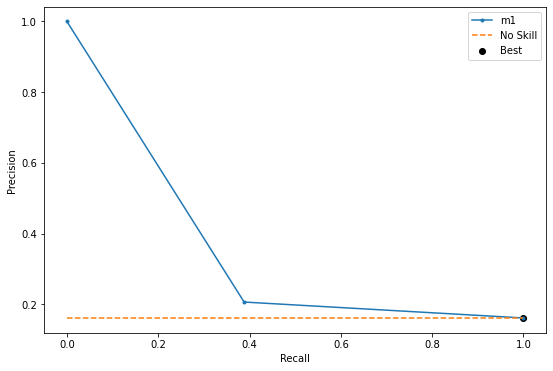


TEST
Best Threshold=0.000000, F-Score=0.278
Confusion matrix 
 [[879 354]
 [145  92]]


In [50]:
recall_precission(y,y_pred_kmeans_1,'m1')

# Method 2 : Reduction of dimension by PCA


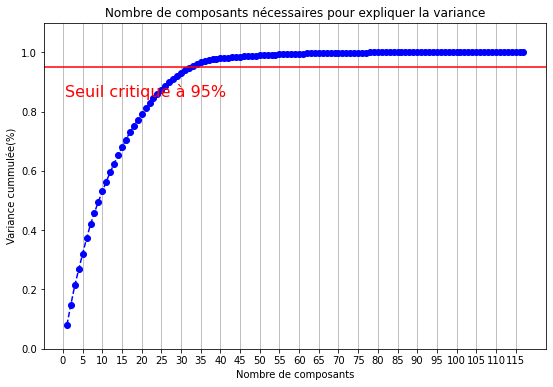

In [19]:
pca = PCA().fit(X_process)

plt.rcParams["figure.figsize"] = (9,6)

fig, ax = plt.subplots()
xi = np.arange(1, 118, step=1)
y_pca = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y_pca, marker='o', linestyle='--', color='b')

plt.xlabel('Nombre de composants')
plt.xticks(np.arange(0, 118, step=5)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Variance cummulée(%)')
plt.title('Nombre de composants nécessaires pour expliquer la variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, 'Seuil critique à 95%', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [20]:
def pca(X):
    pca = PCA(30)
    newX = pca.fit_transform(X)
    newdf = pd.DataFrame(newX)
    newdf.to_pickle('pca.p')
    return (newdf)

In [21]:
X_pca = pca(X_process)
print(X_pca.shape)
X_pca.head()

(1470, 30)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0.436024,-1.171973,0.240467,-0.768354,0.330909,0.883673,-0.513187,-0.666622,-0.468711,1.292881,0.620230,0.481716,0.914570,-0.471435,0.387989,0.392708,-0.765451,-0.763008,-0.557559,-0.074782,0.163441,-0.149231,0.689422,-0.031178,0.001742,0.088383,0.052910,0.157737,-0.108262,0.029778
1,-0.582764,1.375759,1.324941,0.939226,-0.305915,-0.291440,0.176568,-0.783320,0.529012,-1.263881,-0.326624,-0.212903,0.518968,-0.021974,0.311967,-0.740349,-0.313455,0.070826,0.217031,-0.466844,-0.613352,0.339465,0.199751,0.090176,-0.459724,-0.260333,-0.119393,-0.331729,0.409568,0.330398
2,-0.996602,-0.129974,-0.616360,0.141532,1.091248,-0.025273,-0.348431,0.115020,-0.517822,0.727643,0.505913,0.172858,-0.537933,-0.819891,-0.252528,-0.015059,-0.105533,-1.153429,0.444818,0.471989,0.436483,-0.136827,0.044143,0.573757,0.058442,-0.296220,-0.151570,0.054111,-0.076002,0.031873
3,-0.600938,0.024776,-0.791772,0.296172,0.714175,0.050927,0.493760,-0.680809,0.317763,-0.903791,0.624084,1.007484,0.197980,-0.049937,0.885365,0.207749,-0.658909,0.705276,0.603474,0.012702,0.205382,0.119725,0.003096,-0.080678,-0.236221,-0.206056,0.190647,-0.349615,-0.201462,-0.091394
4,-0.667778,0.068198,-0.475900,0.341671,-1.612538,-0.443534,0.129992,0.723315,-0.487073,-0.251233,-0.745828,0.463169,0.874616,-0.780556,-0.571476,-0.401173,0.349772,-0.515866,-0.532836,0.362182,-0.055881,-0.243679,0.648499,0.206362,-0.095895,-0.204050,0.003315,-0.080368,-0.332140,-0.226257


## Use of Kmeans to cluster

In [22]:
y_pred_kmeans_2 = kmeans.fit_predict(X_pca)
accuracy_kmeans = acc(y, y_pred_kmeans_2)
print ('Usual Kmeans precision :' + str(round(accuracy_kmeans, 4)))

Usual Kmeans precision :0.6571


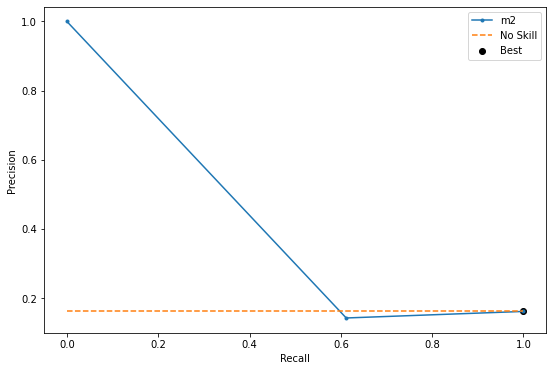


TEST
Best Threshold=0.000000, F-Score=0.278
Confusion matrix 
 [[359 874]
 [ 92 145]]


In [51]:
recall_precission(y,y_pred_kmeans_2,'m2')

# Method 2 : use of kmeans-net

K-means is an unsupervised learning technique that allows similar data to be grouped in the same cluster. Its advantages are that it is simple to explain and adapts well to large samples. However, it is sensitive to outliers and in high dimensions the curse of dimensionality appears.

A solution is to use representation learning. Either by linear reduction using a pre-clustering method via principal component analysis, or by non-linear reduction using an autoencoder. 
Here we are interested in the use of an autoencoder to initialize the centroids of the K-Means classification.
![image.png](attachment:image.png)
We try to apply this process on our dataset.

- Initialization of centroids by autoencoder
- Cluster refinement via Kullback-Leiber
- Performance on the dataset 

## Hyperparameters

In [24]:
dims = [X_process.shape[-1], 20, 20, 2000, 2]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(learning_rate=1, momentum=0.9)

batch_size = 256

## Autoencoder
We will only use the encoder part of the autoencoder and it us train to reduce the dimension

In [25]:
def autoencoder(dims, act='sigmoid', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x) 
     # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

### Visualisation of initial network

In [26]:
autoencoder, encoder = autoencoder(dims, init=init)

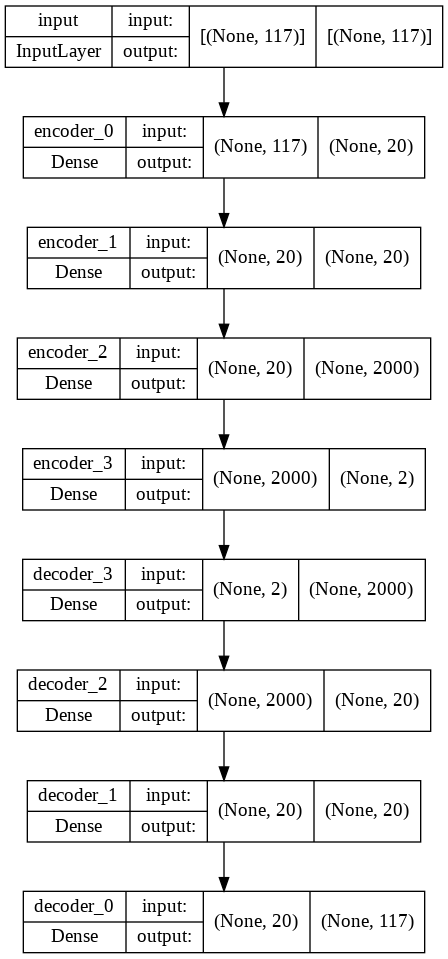

In [27]:
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
Image(filename='autoencoder.png') 

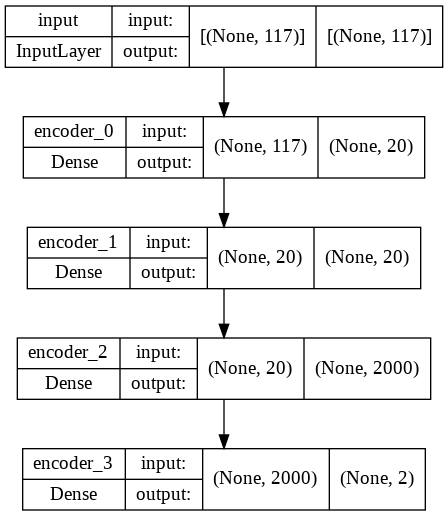

In [28]:
plot_model(encoder, to_file='encoder.png', show_shapes=True)
Image(filename='encoder.png') 

### Fitting of the encoder

In [29]:
%%time
autoencoder.compile(optimizer = pretrain_optimizer, loss = 'kl_divergence')
autoencoder.fit(X_process, X_process, batch_size = batch_size, epochs = 300)

Epoch 1/300
6/6 [==============================] - 2s 22ms/step - loss: 181.9486
Epoch 2/300
6/6 [==============================] - 0s 17ms/step - loss: 165.4699
Epoch 3/300
6/6 [==============================] - 0s 17ms/step - loss: 165.4700
Epoch 4/300
6/6 [==============================] - 0s 16ms/step - loss: 165.4699
Epoch 5/300
6/6 [==============================] - 0s 17ms/step - loss: 165.4699
Epoch 6/300
6/6 [==============================] - 0s 18ms/step - loss: 165.4699
Epoch 7/300
6/6 [==============================] - 0s 19ms/step - loss: 165.4699
Epoch 8/300
6/6 [==============================] - 0s 19ms/step - loss: 165.4699
Epoch 9/300
6/6 [==============================] - 0s 17ms/step - loss: 165.4700
Epoch 10/300
6/6 [==============================] - 0s 15ms/step - loss: 165.4699
Epoch 11/300
6/6 [==============================] - 0s 15ms/step - loss: 165.4699
Epoch 12/300
6/6 [==============================] - 0s 19ms/step - loss: 165.4699
Epoch 13/300
6/6 [=======

## Clustering layer
This clustering layer allows to assign to the encoder outputs (the images compressed in 10 features), a probability to be in each cluster. The weights of this clustering step are initialized with Kmeans once the dimensionality is reduced.

In [30]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape = (self.n_clusters, input_dim), initializer='glorot_uniform', name = 'clusters') 
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [31]:
autoencoder.save_weights('/content/ae_weights.h5')

In [32]:
autoencoder.load_weights('/content/ae_weights.h5')

In [33]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

### Visualisation of the final network

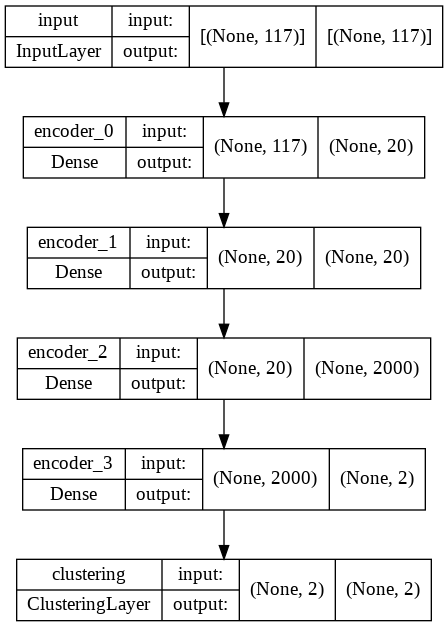

In [34]:
plot_model(model, to_file='model.png', show_shapes=True)
Image(filename='model.png') 

In [35]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

## Initialisation of centroïds via Kmeans
Now that the dimensionality of each image is reduced to 10, KMeans can more easily generate the centroids, which we will improve with the Kullback Leibler divergence.

In [36]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(X_process))

In [37]:
y_pred_last = np.copy(y_pred)

In [38]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

## Kulback Leiber
Now we improve the clustering by defining a target distribution and minimizing the clustering distribution with the target distribution using the Kullback Leibler divergence.

In [39]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [40]:
loss = 0
index = 0
maxiter = 8000
update_interval = 50
index_array = np.arange(X_process.shape[0])
tol = 0.001 # tolerance threshold to stop training

In [41]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(X_process, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc1 = np.round(acc(y, y_pred), 5)
            print('Itération n° : ' + str(ite) + ', accuracy : ' + str(acc1) + ', loss : ' + str(loss))

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Tolerance threshold reached.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, X_process.shape[0])]
    loss = model.train_on_batch(x=X_process[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= X_process.shape[0] else 0

Itération n° : 0, accuracy : 0.50136, loss : 0
Itération n° : 50, accuracy : 0.50136, loss : 2.3668007997912355e-07
delta_label  0.0 < tol  0.001
Tolerance threshold reached.


In [42]:
q = model.predict(X_process, verbose=0)
p = target_distribution(q) 

# evaluate the clustering performance
y_kmeansnet = q.argmax(1)
if y is not None:
    acc1 = np.round(acc(y, y_kmeansnet), 5)
    loss1 = np.round(loss, 5)
    print('Accuracy : ' + str(acc1) + ', loss : ' + str(loss))
    

Accuracy : 0.50136, loss : 2.3668007997912355e-07


In [43]:
accuracy_kmeansnet = acc(y,y_kmeansnet)
print("Précision KmeansNet : " + str(round(accuracy_kmeansnet, 4)))

Précision KmeansNet : 0.5014


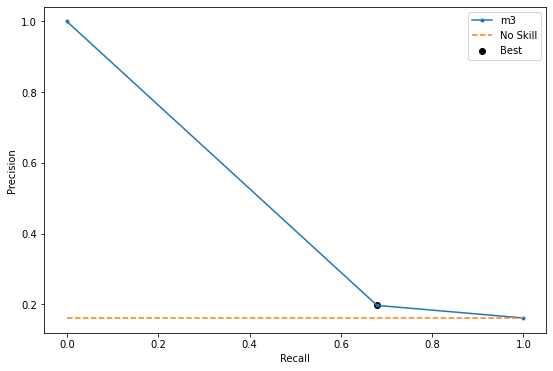


TEST
Best Threshold=1.000000, F-Score=0.305
Confusion matrix 
 [[576 657]
 [ 76 161]]


In [52]:
recall_precission(y,y_kmeansnet,'m3')